<a href="https://colab.research.google.com/github/KaterynaRb/furniture-store-analysis/blob/main/FurnitureStoreAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrieving information from the database

In [ ]:
# This command will update the google-cloud-bigquery library
# for working with Google BigQuery if it is already installed:
!pip install --upgrade google-cloud-bigquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.9/258.9 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: google-cloud-bigquery
    Found existing installation: google-cloud-bigquery 3.36.0
    Uninstalling google-cloud-bigquery-3.36.0:
      Successfully uninstalled google-cloud-bigquery-3.36.0


In [ ]:
# Modules for authentication and BigQuery
from google.colab import auth
from google.cloud import bigquery

# Modules for data processing and visualisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Authentication before working with Google Cloud
auth.authenticate_user()

In [ ]:
# Create client for working with BigQuery,
# specifying ID of the working project in Google Cloud:
client = bigquery.Client(project="data-analytics-mate")

In [ ]:
# Query for retrieving data from BigQuery
query = """
WITH
  sessions_params AS (
  SELECT
    s.*,
    sp.* EXCEPT(ga_session_id)
  FROM
    `data-analytics-mate.DA.session` s
  JOIN
    `data-analytics-mate.DA.session_params` sp
  ON
    s.ga_session_id = sp.ga_session_id ),
  account_params AS (
  SELECT
    acc.is_verified,
    acc.is_unsubscribed,
    acs.*
  FROM
    `data-analytics-mate.DA.account` acc
  LEFT JOIN
    `data-analytics-mate.DA.account_session` acs
  ON
    acc.id = acs.account_id),
  product_params AS (
  SELECT
    p.name AS product_name,
    p.category AS product_category,
    p.price,
    p.short_description,
    o.ga_session_id
  FROM
    `data-analytics-mate.DA.product` p
  JOIN
    `data-analytics-mate.DA.order` o
  ON
    p.item_id = o.item_id)
SELECT
  sep.*,
  acp.* EXCEPT(ga_session_id),
  prp.* EXCEPT(ga_session_id)
FROM
  sessions_params sep
LEFT JOIN
  account_params acp
ON
  sep.ga_session_id = acp.ga_session_id
LEFT JOIN
  product_params prp
ON
  sep.ga_session_id = prp.ga_session_id
"""

query_job = client.query(query)  # Executing SQL-query
results = query_job.result()  # Waiting for the results

# Short description of the created DataFrame

In [ ]:
# Creating DataFrame from query results
session_order_df = results.to_dataframe()
session_order_df.head()

,date,ga_session_id,device,mobile_model_name,operating_system,language,browser,continent,country,medium,name,channel,is_verified,is_unsubscribed,account_id,product_name,product_category,price,short_description
0,2021-01-19,7268004754,desktop,Chrome,Web,en-gb,Chrome,(not set),(not set),(none),(direct),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
1,2021-01-06,8321293308,desktop,Chrome,Web,None,Chrome,(not set),(not set),(none),(direct),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
2,2020-11-05,4392362373,desktop,Chrome,Web,None,Chrome,(not set),(not set),organic,(organic),Organic Search,<NA>,<NA>,<NA>,None,None,NaN,None
3,2020-12-09,140108698,desktop,Safari,Web,en-us,Chrome,(not set),(not set),(none),(direct),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
4,2020-11-10,8351127264,mobile,iPhone,Web,en-us,Safari,(not set),(not set),organic,(organic),Organic Search,<NA>,<NA>,<NA>,None,None,NaN,None


In [ ]:
print(session_order_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               349545 non-null  dbdate 
 1   ga_session_id      349545 non-null  Int64  
 2   device             349545 non-null  object 
 3   mobile_model_name  349545 non-null  object 
 4   operating_system   349545 non-null  object 
 5   language           235279 non-null  object 
 6   browser            349545 non-null  object 
 7   continent          349545 non-null  object 
 8   country            349545 non-null  object 
 9   medium             349545 non-null  object 
 10  name               349545 non-null  object 
 11  channel            349545 non-null  object 
 12  is_verified        27945 non-null   Int64  
 13  is_unsubscribed    27945 non-null   Int64  
 14  account_id         27945 non-null   Int64  
 15  product_name       33538 non-null   object 
 16  pr

Total number of columns: 19

Numerical columns:
- (float64): 1
  - price

Categorical columns:
- (Int64): 4
  - ga_session_id
  - account_id
  - is_verified (boolean)
  - is_unsubscribed (boolean)
- (object) 13
  - device
  - mobile_model_name
  - operating_system
  - language
  - browser
  - continent
  - country
  - medium
  - name
  - channel
  - product_name
  - product_category
  - short_description

Datetime columns:
- (Returned from SQL query in type: dbdate) 1
  - date

In [ ]:
print(session_order_df['price'].describe())

count    33538.000000
mean       953.298679
std       1317.001775
min          3.000000
25%        170.000000
50%        445.000000
75%       1195.000000
max       9585.000000
Name: price, dtype: float64


The median is lower than the average, indicating asymmetry in the distribution of prices. Most orders were small.

In [ ]:
nunique_sessions = session_order_df['ga_session_id'].nunique()
print(f'Number of unique sessions {nunique_sessions}', end='\n\n')

from datetime import datetime, timedelta

first_date = np.min(session_order_df['date'])
last_date = np.max(session_order_df['date'])
print(f'Data from period: {first_date} — {last_date}')
print(f'Total days: {last_date - first_date + timedelta(days=1)}',
      end='\n\n')

print('Missing values percentage:')
print(session_order_df.isna().sum() / session_order_df.shape[0] * 100,
      end='\n\n')

print('Unique values:')
print(session_order_df['browser'].value_counts(), end='\n\n')
print(session_order_df['device'].value_counts(), end='\n\n')
print(session_order_df['channel'].value_counts(), end='\n\n')
print(session_order_df['continent'].value_counts())

Number of unique sessions 349545

Data from period: 2020-11-01 — 2021-01-31
Total days: 92 days, 0:00:00

Missing values percentage:
date                  0.000000
ga_session_id         0.000000
device                0.000000
mobile_model_name     0.000000
operating_system      0.000000
language             32.689925
browser               0.000000
continent             0.000000
country               0.000000
medium                0.000000
name                  0.000000
channel               0.000000
is_verified          92.005321
is_unsubscribed      92.005321
account_id           92.005321
product_name         90.405241
product_category     90.405241
price                90.405241
short_description    90.405241
dtype: float64

Unique values:
browser
Chrome             238460
Safari              83254
<Other>              8930
Edge                 8023
Firefox              6433
Android Webview      4445
Name: count, dtype: int64

device
desktop    204429
mobile     137267
tablet       

There are missing values in the language column and in columns that contain information about accounts and products. The reason is the table has data about all sessions, including those without orders, or sessions from unregistered accounts. As for the language column, there might be missing values because of browser settings, for example. There are also some undefined data in browser, channel, continent columns.

# Sales analysis

## Sales geography

In [ ]:
# Top continents and countries by sales
sales_by_continent = (
    session_order_df
    .groupby('continent')['price']
    .sum()
    .reset_index(name='sales')
    )

sales_by_continent.sort_values(by='sales', ascending=False, inplace=True)

print('Top continents by sales:')
print(sales_by_continent.head(3), end='\n\n')

sales_by_country = (
    session_order_df
    .groupby('country')['price']
    .sum()
    .reset_index(name='sales')
    )

sales_by_country.sort_values(by='sales', ascending=False, inplace=True)

print('Top countries by sales:')
print(sales_by_country.head(5), end='\n\n')

Top continents by sales:
  continent       sales
2  Americas  17665280.0
3      Asia   7601298.3
4    Europe   5934624.2

Top countries by sales:
            country       sales
104   United States  13943553.9
43            India   2809762.0
18           Canada   2437921.0
103  United Kingdom    938317.9
33           France    710692.8



In [ ]:
# Top continents and countries by number of orders
orders_by_continent = (
    session_order_df
    .groupby('continent')['price']
    .count()
    .reset_index(name='n_orders')
    )

orders_by_continent.sort_values(by='n_orders',ascending=False, inplace=True)

print('Top continents by number of orders:')
print(orders_by_continent.head(3), end='\n\n')

orders_by_country = (
    session_order_df
    .groupby('country')['price']
    .count()
    .reset_index(name='n_orders')
    )

orders_by_country.sort_values(by='n_orders', ascending=False, inplace=True)

print('Top countries by number of orders:')
print(orders_by_country.head(5), end='\n\n')

Top continents by number of orders:
  continent  n_orders
2  Americas     18553
3      Asia      7950
4    Europe      6261

Top countries by number of orders:
            country  n_orders
104   United States     14673
43            India      3029
18           Canada      2560
103  United Kingdom      1029
33           France       678



Distribution by top continets and countries is the same both for sales and for number of orders.

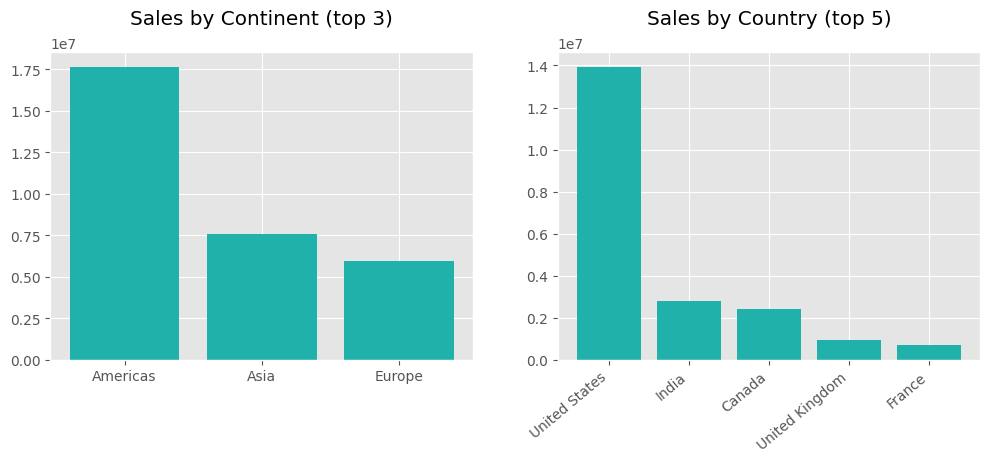

In [ ]:
# Setting default visual properties for plots
plt.style.use('ggplot')
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['figure.figsize'] = (14, 4)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].bar(x=sales_by_continent['continent'][:3],
          height=sales_by_continent['sales'][:3],
          color='lightseagreen')

ax[0].set_title('Sales by Continent (top 3)')

ax[1].bar(x=sales_by_country['country'][:5],
          height=sales_by_country['sales'][:5],
          color='lightseagreen')

ax[1].set_xticks(sales_by_country['country'][:5])
ax[1].set_xticklabels(sales_by_country['country'][:5],
                      rotation=40, ha='right')
ax[1].set_title('Sales by Country (top 5)')

plt.show()

## Sales by category

In [ ]:
# Top 10 categories by total sales
sales_by_category = (
    session_order_df
    .groupby('product_category')['price']
    .agg(['sum', 'count'])
    .reset_index()
    .rename(columns={'sum': 'sales', 'count': 'n_orders'})
    )

sales_by_category.sort_values(by='sales', ascending=False, inplace=True)

print('Top categories by sales:')
print(sales_by_category.head(10).to_markdown(), end='\n\n')

# Top 10 categories by sales in the country with the highest total sales
top_country = sales_by_country.iloc[0, 0]

sales_by_category_top_country = (
    session_order_df[session_order_df['country'] == top_country]
    .groupby('product_category')['price']
    .agg(['sum', 'count'])
    .reset_index()
    .rename(columns={'sum': 'sales', 'count': 'n_orders'})
    )

sales_by_category_top_country['percent_of_total_sales'] = (
    sales_by_category_top_country['sales'] / sales_by_category['sales'] * 100
    )

sales_by_category_top_country.sort_values(by='sales',
                                          ascending=False,
                                          inplace=True)

print(f'Top categories by sales in {top_country}:')
print(sales_by_category_top_country.head(10).to_markdown(), end='\n\n')

Top categories by sales:
|    | product_category                 |            sales |   n_orders |
|---:|:---------------------------------|-----------------:|-----------:|
| 12 | Sofas & armchairs                |      8.38825e+06 |       4301 |
|  5 | Chairs                           |      6.14775e+06 |       5952 |
|  1 | Beds                             |      4.91972e+06 |       2926 |
|  2 | Bookcases & shelving units       |      3.64082e+06 |       7630 |
|  3 | Cabinets & cupboards             |      2.3365e+06  |       2318 |
|  9 | Outdoor furniture                |      2.14222e+06 |       2229 |
| 13 | Tables & desks                   |      1.79031e+06 |       2941 |
|  6 | Chests of drawers & drawer units | 906562           |       1452 |
|  0 | Bar furniture                    | 735503           |       1092 |
|  7 | Children's furniture             | 467697           |       1702 |

Top categories by sales in United States:
|    | product_category                 |   

In the country with the highest total sales there are the same top 10 categories as in total.

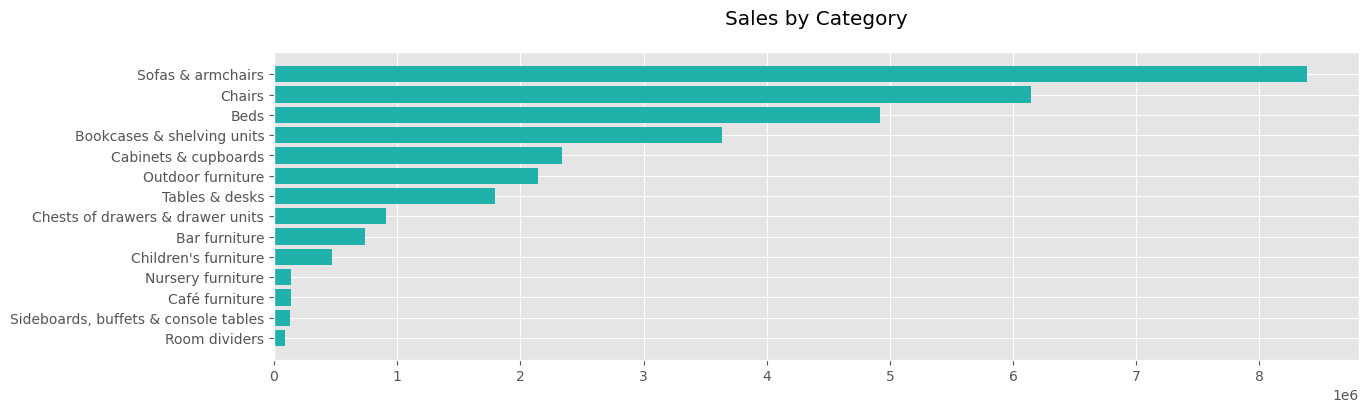

In [ ]:
# Plot for categories
sales_by_category.sort_values(by='sales', ascending=True, inplace=True)

plt.barh(y=sales_by_category['product_category'],
         width=sales_by_category['sales'],
         color='lightseagreen')

plt.title('Sales by Category')
plt.show()

The highest sales by category come from *Sofas & armchairs, Chairs, Beds, Bookcases & Shelving units*

## Sales by device and channel

In [ ]:
# Sales by device with percent of total
sales_by_device = (
    session_order_df
    .groupby('device')['price']
    .sum()
    .reset_index(name='sales')
    )

sales_by_device['sales_percentage'] = (
    sales_by_device['sales']/ sum(sales_by_device['sales']) * 100
    )

sales_by_device.sort_values(by='sales', ascending=False, inplace=True)
print(sales_by_device, end='\n\n')

# Sales by device and mobile model with percent of total
sales_by_model = (
    session_order_df
    .groupby(['device', 'mobile_model_name'])['price']
    .sum()
    .reset_index(name='sales')
    )

sales_by_model['sales_percentage'] = (
    sales_by_model['sales'] / sum(sales_by_model['sales']) * 100
    )

print(sales_by_model, end='\n\n')

# Sales by channel with percent of total
sales_by_channel = (
    session_order_df
    .groupby('channel')['price']
    .sum()
    .reset_index(name='sales')
    )

sales_by_channel['sales_percentage'] = (
    sales_by_channel['sales'] / sum(sales_by_channel['sales']) * 100
    )

sales_by_channel.sort_values(by='sales', ascending=False, inplace=True)
print(sales_by_channel)

    device       sales  sales_percentage
0  desktop  18864039.0         59.002245
1   mobile  12384225.8         38.734924
2   tablet    723466.3          2.262831

     device mobile_model_name      sales  sales_percentage
0   desktop           <Other>   525645.1          1.644093
1   desktop            Chrome  8899523.9         27.835602
2   desktop        ChromeBook  1830458.7          5.725241
3   desktop              Edge   696877.3          2.179667
4   desktop           Firefox   421066.9          1.316998
5   desktop            Safari  6490467.1         20.300643
6    mobile           <Other>  5735073.6         17.937951
7    mobile              Edge      345.0          0.001079
8    mobile           Pixel 3   109148.2          0.341390
9    mobile        Pixel 4 XL   118287.7          0.369976
10   mobile            Safari      595.0          0.001861
11   mobile            iPhone  6420776.3         20.082667
12   tablet           <Other>   274612.1          0.858922
13   tabl

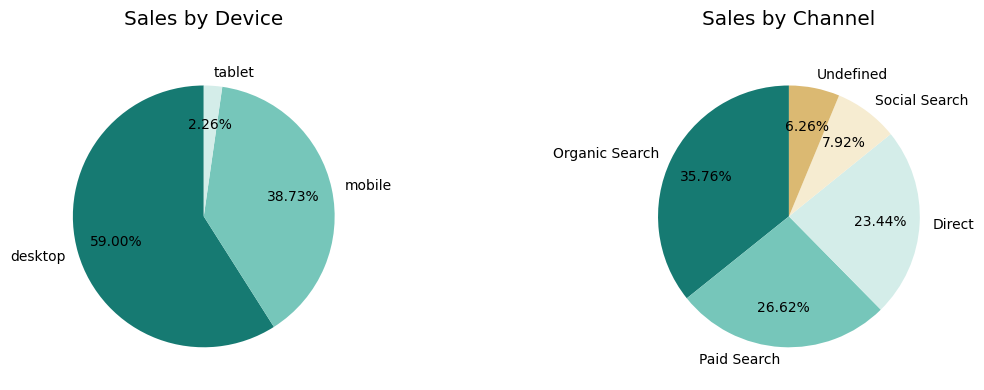

In [ ]:
# Plots for sales by channel, device and mobile model
fig, ax = plt.subplots(1, 2, figsize=(12,4))

colors = sns.color_palette('BrBG_r')

ax[0].pie(x=sales_by_device['sales'],
          labels=sales_by_device['device'],
          colors=colors, autopct='%.2f%%',
          pctdistance=0.7, startangle=90,
          textprops={'fontsize': 10})

ax[0].set_title('Sales by Device')

ax[1].pie(x=sales_by_channel['sales'],
          labels=sales_by_channel['channel'],
          colors=colors, autopct='%.2f%%',
          pctdistance=0.7, startangle=90,
          textprops={'fontsize': 10})

ax[1].set_title('Sales by Channel')

plt.tight_layout()
plt.show()

The highest sales by devices come from *desktop devices*, followed by *mobile devices*, and the lowest sales come from *tablets*.

By channel, the highest sales come from *Organic Search, Paid Search* and *Direct*

## Users' behavior

In [ ]:
n_registered_users = session_order_df['account_id'].nunique()
n_unsubscribed_users = session_order_df[session_order_df['is_unsubscribed'] == 1]['account_id'].nunique()

n_verified_users = (
    session_order_df[session_order_df['is_verified'] == 1]['account_id']
    .nunique()
    )

print(f'Number of registered users: {n_registered_users}')

verified_users_percentage = round(n_verified_users / n_registered_users * 100, 2)
print(f'Percentage of registered users that verified their email: {verified_users_percentage} %')

unsubscribed_users_percentage = round(n_unsubscribed_users / n_registered_users * 100, 2)
print(f'Percentage of registered users that unsubscribed: {unsubscribed_users_percentage} %', end ='\n\n')

Number of registered users: 27945
Percentage of registered users that verified their email: 71.7 %
Percentage of registered users that unsubscribed: 16.94 %



In [ ]:
# Countries by number of registered users
registered_users_by_country = (
    session_order_df
    .groupby('country')['account_id']
    .nunique()
    .reset_index(name='registered_users')
    )

registered_users_by_country.sort_values(by='registered_users',
                                        ascending=False,
                                        inplace=True)

print('Countries with the biggest number of registered users:')
print(registered_users_by_country.head(5))

Countries with the biggest number of registered users:
            country  registered_users
104   United States             12384
43            India              2687
18           Canada              2067
103  United Kingdom               859
33           France               553


The top 5 countries with the biggest number of registered users are the same as the countries with the highest sales, as expected.

In [ ]:
# Summary for subscribed and unsubscribed users
sales_by_subscription = (
    session_order_df[session_order_df['price'].notnull()]
    .groupby('is_unsubscribed')['price']
    .agg(total_sales='sum', mean_price='mean', orders_count='count')
    .reset_index()
    .rename(columns={'is_unsubscribed': 'status'})
    )

status_map = {1: 'Unsubscribed', 0: 'Subscribed'}
sales_by_subscription['status'] = sales_by_subscription['status'].map(status_map)

print("Summary by User Type")
print(sales_by_subscription, end='\n\n')

Summary by User Type
         status  total_sales  mean_price  orders_count
0    Subscribed    2150796.9  921.506812          2334
1  Unsubscribed     431721.6  965.820134           447



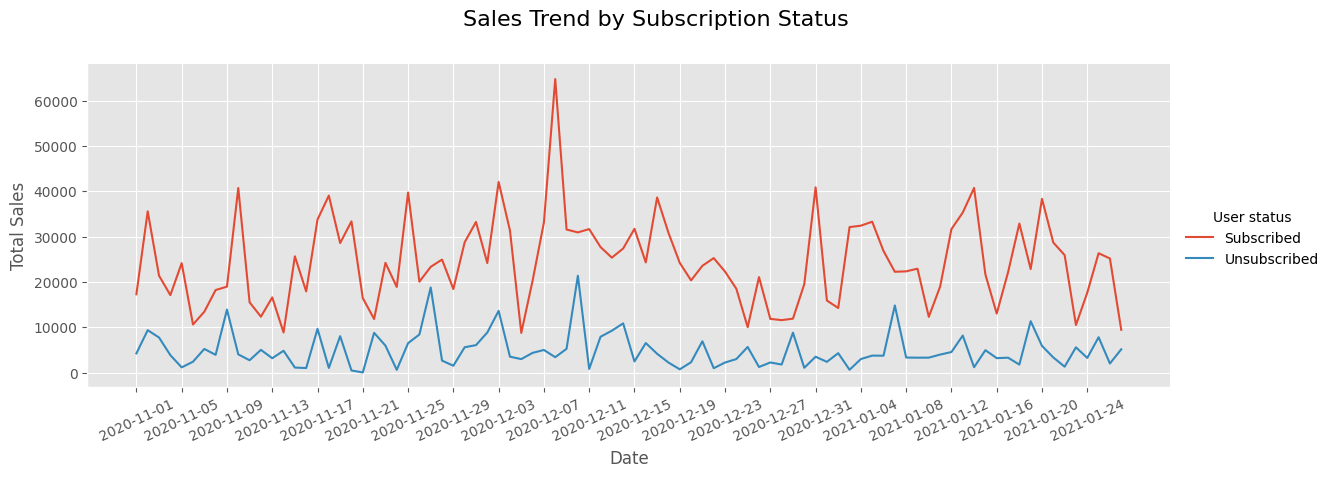

In [ ]:
# Sales trend by user type over time
sales_by_subscription_dynamic = (
    session_order_df
    .groupby(['date', 'is_unsubscribed'])['price']
    .sum()
    .reset_index(name='sales')
    .rename(columns={'is_unsubscribed': 'status'})
    )

sales_by_subscription_dynamic['status'] = (
    sales_by_subscription_dynamic['status'].map(status_map)
    )

# Plot
g = sns.relplot(
    data=sales_by_subscription_dynamic,
    x='date',
    y='sales',
    kind='line',
    hue='status',
    height=4,
    aspect=3
    )

g._legend.set_title("User status")
g.set_axis_labels('Date', 'Total Sales')
plt.xticks(sales_by_subscription_dynamic['date'][::8], rotation=25)
plt.suptitle('Sales Trend by Subscription Status', y=1.1)
plt.show()

The dynamics show that the behavior of users who subscribed to the mailing list and unsubscribed from it differs. In general, mean order sum does not differ much for subscribed and unsubscribed users. There are more subscribed users, so they make more orders and bring more income.

# Sales dynamic

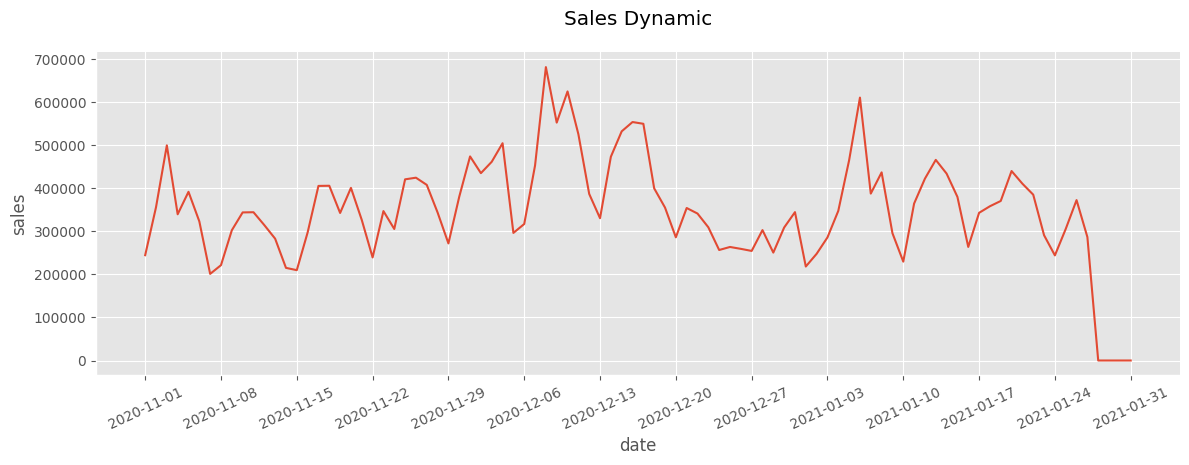

In [ ]:
sales_dynamic = (
    session_order_df
    .groupby('date')['price']
    .sum()
    .reset_index(name='sales')
    )

g = sns.relplot(
    data=sales_dynamic,
    x='date',
    y='sales',
    kind='line',
    height=4,
    aspect=3
    )

plt.xticks(sales_dynamic['date'][::7], rotation=25) # Set label locations (every 7 days)
plt.title('Sales Dynamic')

plt.show()

There is weekly seasonality in the sales. Also, on the plot, there are four last days without any orders.

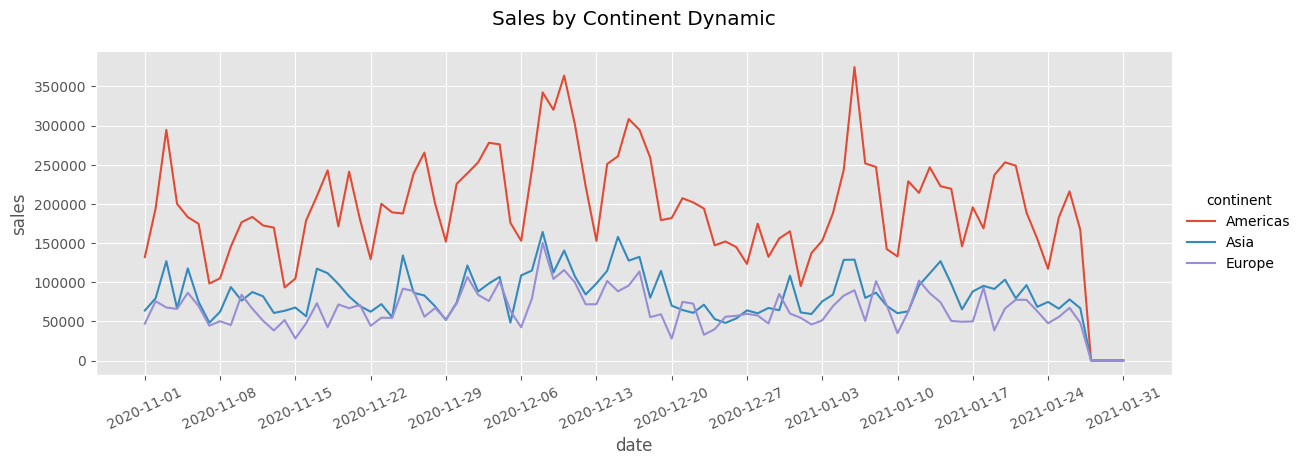

In [ ]:
sales_by_continent_dynamic = (
    session_order_df
    .groupby(['date', 'continent'])['price']
    .sum()
    .reset_index(name='sales')
    )

continents_to_show = ['Americas', 'Asia', 'Europe']
sns.relplot(
    data=sales_by_continent_dynamic,
    x='date',
    y='sales',
    kind='line',
    hue='continent',
    height=4,
    aspect=3,
    hue_order=continents_to_show
    )

plt.xticks(sales_dynamic['date'][::7], rotation=25)
plt.title('Sales by Continent Dynamic')

plt.show()

There are similar patterns of sales dynamics for the top 3 continents. The most income comes from the *Americas* every day. Then from *Asia* and *Europe*, as was also seen on the of the bar charts.

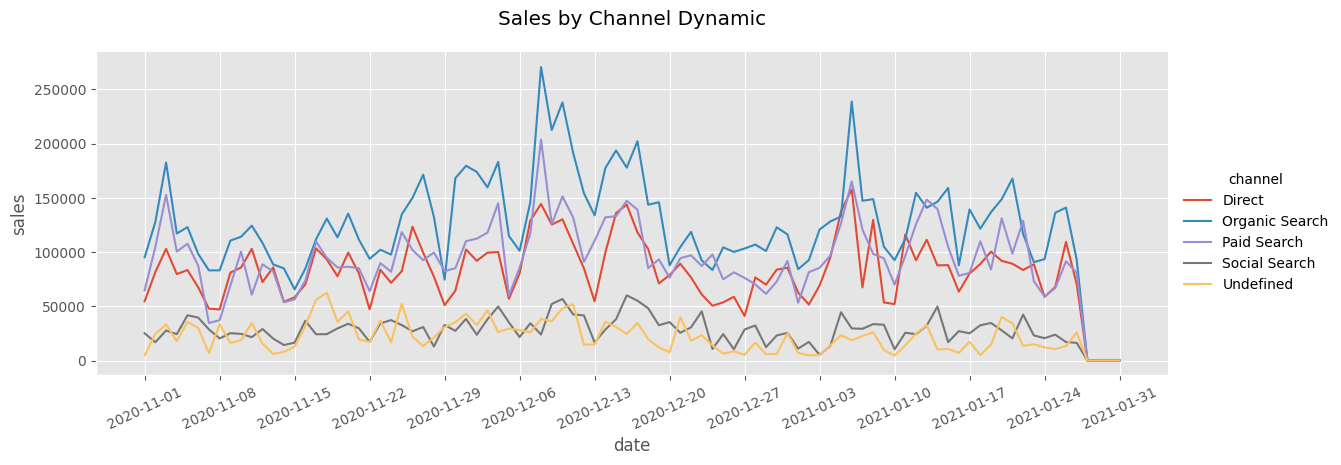

In [ ]:
sales_by_channel_dynamic = (
    session_order_df
    .groupby(['date', 'channel'])['price']
    .sum()
    .reset_index(name='sales')
    )

sns.relplot(
    data=sales_by_channel_dynamic,
    x='date',
    y='sales',
    kind='line',
    hue='channel',
    height=4,
    aspect=3
    )

plt.xticks(sales_dynamic['date'][::7], rotation=25)
plt.title('Sales by Channel Dynamic')

plt.show()

There are similar patterns of sales dynamics for the top 3 channels. As for *Social Search* and *Undefined*, patterns are slightly different, having peaks on other days than the top 3 channels.


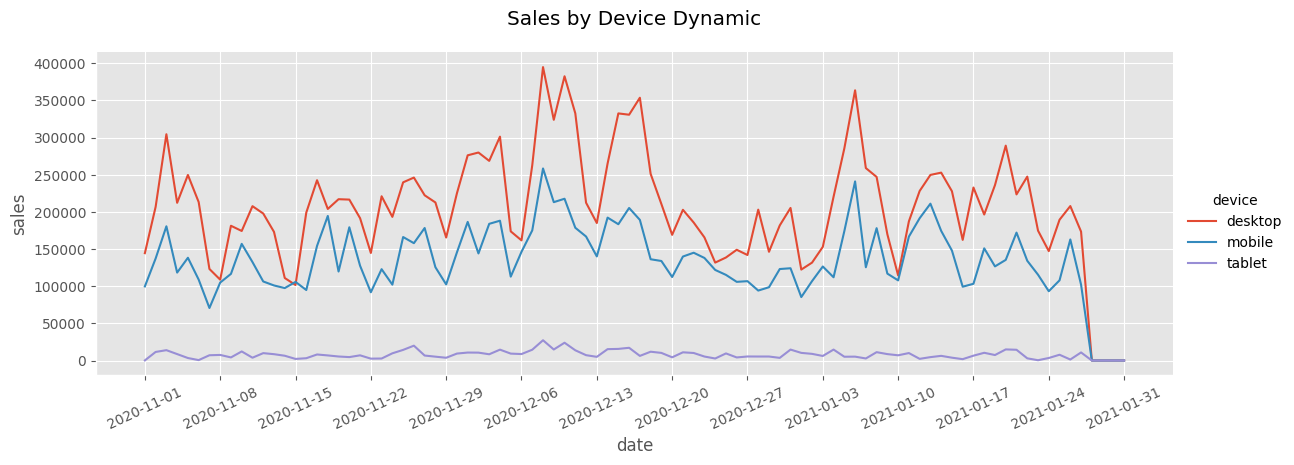

In [ ]:
sales_by_device_dynamic = (
    session_order_df
    .groupby(['date', 'device'])['price']
    .sum()
    .reset_index(name='sales')
    )

sns.relplot(
    data=sales_by_device_dynamic,
    x='date',
    y='sales',
    kind='line',
    hue='device',
    height=4,
    aspect=3
    )

plt.xticks(sales_dynamic['date'][::7], rotation=25)
plt.title('Sales by Device Dynamic')

plt.show()

There are similar patterns of sales dynamics for devices. The most income comes from *desktops* almost every day. It is also shown that the income from *tablets* is significantly lower than from *desktops* or *mobile devices*.

# Pivot tables

In [ ]:
# Number of sessions by traffic channels and device types
session_cnt_channel_device = (
    pd.pivot_table(session_order_df,
                   values='ga_session_id',
                   index='channel',
                   columns='device',
                   aggfunc='count')
    )

print(session_cnt_channel_device)

device          desktop  mobile  tablet
channel                                
Direct            47825   31745    1812
Organic Search    72622   49014    2789
Paid Search       55167   37034    2140
Social Search     16288   10988     638
Undefined         12527    8486     470


The largest number of sessions comes from Organic Search and Paid Search channels, and desktop devices. Next are Organic Search from mobile and Direct from desktop. The smallest number of sessions from all channels come from tablet users.

In [ ]:
# Pivot table for total sales by product category (top 10 categories)
# in different countries (top 5 countries)

top_countries = sales_by_country['country'][:5]

sales_by_category.sort_values(by='sales', ascending=False, inplace=True)
top_categories = sales_by_category['product_category'][:10]

# Selecting needed data from original dataset
sales_categories_countries = (
    session_order_df[(session_order_df['country'].isin(top_countries))
        & (session_order_df['product_category'].isin(top_categories))])

# Set both columns to Categorical with desired order
sales_categories_countries['country'] = pd.Categorical(
    sales_categories_countries['country'],
    categories=top_countries,
    ordered=True
    )

sales_categories_countries['product_category'] = pd.Categorical(
    sales_categories_countries['product_category'],
    categories=top_categories,
    ordered=True
    )

sales_categories_countries = (
    pd.pivot_table(sales_categories_countries,
                   values='price',
                   index='product_category',
                   columns='country',
                   aggfunc='sum')
    )

print(sales_categories_countries.to_markdown())

| product_category                 |    United States |   India |   Canada |   United Kingdom |   France |
|:---------------------------------|-----------------:|--------:|---------:|-----------------:|---------:|
| Sofas & armchairs                |      3.70714e+06 |  788430 |   692428 |         234812   | 187735   |
| Chairs                           |      2.61977e+06 |  544309 |   417741 |         188519   | 134029   |
| Beds                             |      2.21306e+06 |  358320 |   354772 |         133816   | 116414   |
| Bookcases & shelving units       |      1.56761e+06 |  364507 |   278982 |         113988   |  73830   |
| Cabinets & cupboards             | 994546           |  191888 |   181802 |          71684.5 |  59101.5 |
| Outdoor furniture                | 929245           |  162289 |   185323 |          57002.4 |  40486.4 |
| Tables & desks                   | 777865           |  186158 |   132678 |          49374   |  42299   |
| Chests of drawers & drawer units | 

/tmp/ipython-input-2122357644.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_categories_countries['country'] = pd.Categorical(
/tmp/ipython-input-2122357644.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_categories_countries['product_category'] = pd.Categorical(
/tmp/ipython-input-2122357644.py:28: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain t

Tables & desks are sold more than Outdoor furniture in India and France. And Outdoor furniture are sold more than Cabinets & cupboards in Canada.

In [ ]:
# Number of unsubscribed and subscribed users by traffic channels
channel_usertype = (
    pd.pivot_table(session_order_df,
                   values='account_id',
                   index='channel',
                   columns='is_unsubscribed',
                   aggfunc='count')
    )

channel_usertype = channel_usertype.apply(lambda x: x / x.sum() * 100, axis=1)
print(channel_usertype)

is_unsubscribed          0          1
channel                              
Direct           82.990482  17.009518
Organic Search   82.660688  17.339312
Paid Search      83.393599  16.606401
Social Search    83.770344  16.229656
Undefined        83.226558  16.773442


The distribution of unsubscribed and subscribed users is almost the same for all traffic channels.

# Relationship analysis

## Sessions Count vs Total Sales

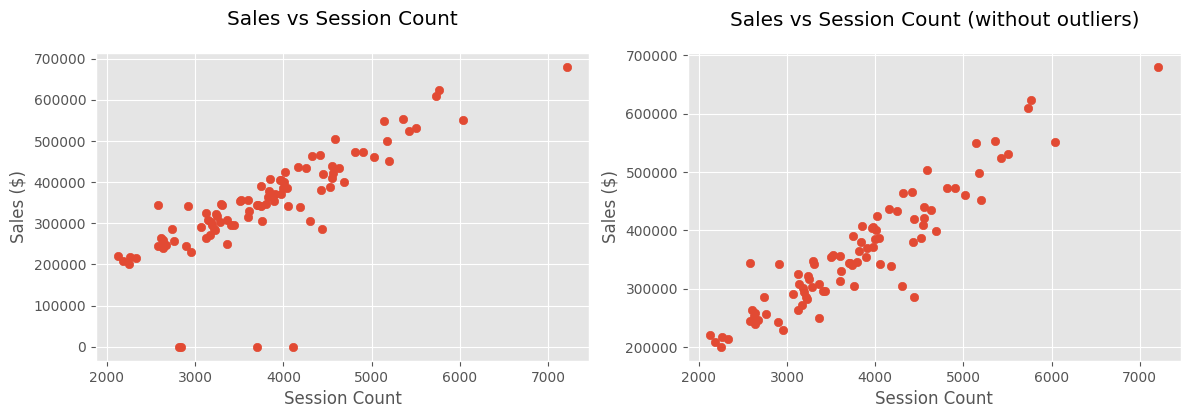

In [ ]:
# Session count and sales for each day
sessions_sales = (
    pd.pivot_table(session_order_df,
                   index='date',
                   values=['ga_session_id', 'price'],
                   aggfunc={'ga_session_id':'count', 'price':'sum'})
    .rename(columns={'ga_session_id':'session_cnt', 'price':'sales'})
    )

sessions_sales_wo_outliers = sessions_sales.iloc[:88, :] # without last 4 days

fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].scatter(sessions_sales['session_cnt'],
              sessions_sales['sales'])
ax[0].set_title('Sales vs Session Count')
ax[0].set_xlabel('Session Count')
ax[0].set_ylabel('Sales ($)')

ax[1].scatter(sessions_sales_wo_outliers['session_cnt'],
              sessions_sales_wo_outliers['sales'])
ax[1].set_title('Sales vs Session Count (without outliers)')
ax[1].set_xlabel('Session Count')
ax[1].set_ylabel('Sales ($)')

plt.show()

The graph shows a positive correlation between the number of sessions and total sales for each date. It also shows that the correlation can be estimated more accurately if outliers are not taken into account.

In [ ]:
from scipy.stats import shapiro, spearmanr

# Normality test to choose method for correlation
# Shapiro-Wilk test
_, p_value_shapiro_cnt = shapiro(sessions_sales['session_cnt'])
_, p_value_shapiro_sales = shapiro(sessions_sales['sales'])
_, p_value_shapiro_cnt_wo_outliers = shapiro(sessions_sales_wo_outliers['session_cnt'])
_, p_value_shapiro_sales_wo_outliers = shapiro(sessions_sales_wo_outliers['sales'])

print(f'Shapiro-Wilk p-value for number of sessions: {p_value_shapiro_cnt}')
print(f'Shapiro-Wilk p-value for sales: {p_value_shapiro_sales} \n')
print(f'Shapiro-Wilk p-value for number of sessions for outlier-free data: {p_value_shapiro_cnt_wo_outliers}')
print(f'Shapiro-Wilk p-value for sales for outlier-free data: {p_value_shapiro_sales_wo_outliers} \n')

Shapiro-Wilk p-value for number of sessions: 0.026201156314308208
Shapiro-Wilk p-value for sales: 0.0017206798751357067 

Shapiro-Wilk p-value for number of sessions for outlier-free data: 0.03948838648168485
Shapiro-Wilk p-value for sales for outlier-free data: 0.0047925668386651875 



The Shapiro-Wilk method is used because it is better suited for small sample sizes. The p-value is less than 0.05, therefore the hypothesis that the data is normally distributed is rejected. (For abnormal distribution, the p-value is expected to be less than 0.05, indicating a deviation from normality.) Therefore, the Spearman method is used because it is more suitable for ranked data or quantitative data that is not normally distributed.

In [ ]:
# Calculate Spearman correlation.
spearman_session_sales = spearmanr(sessions_sales['session_cnt'],
                                   sessions_sales['sales'])
print(
    f"Spearman Correlation for data with outliers and p-value:\n\
     {spearman_session_sales}\n"
)

# Calculate Spearman correlation for data without outliers
spearman_session_sales_wo_outliers = spearmanr(sessions_sales_wo_outliers['session_cnt'],
                                               sessions_sales_wo_outliers['sales'])
print(
    f"Spearman Correlation for data without outliers and p-value:\n\
     {spearman_session_sales_wo_outliers}"
)

Spearman Correlation for data with outliers and p-value:
     SignificanceResult(statistic=np.float64(0.8653062174563682), pvalue=np.float64(9.755923586156614e-29))

Spearman Correlation for data without outliers and p-value:
     SignificanceResult(statistic=np.float64(0.904283047444613), pvalue=np.float64(1.5381769633064087e-33))


Spearman's coefficient of 0.87 (for data with outliers) and 0.9 (for data without outliers) indicates a strong positive correlation between the number of sessions and total sales, which was also shown on the graphs. If we exclude outliers that affect the correlation coefficient, we see that the coefficient is slightly higher. Also, pvalue < 0.05 indicates that the result is statistically significant, therefore, a strong positive correlation is indeed present.

## Sales by continents correlation

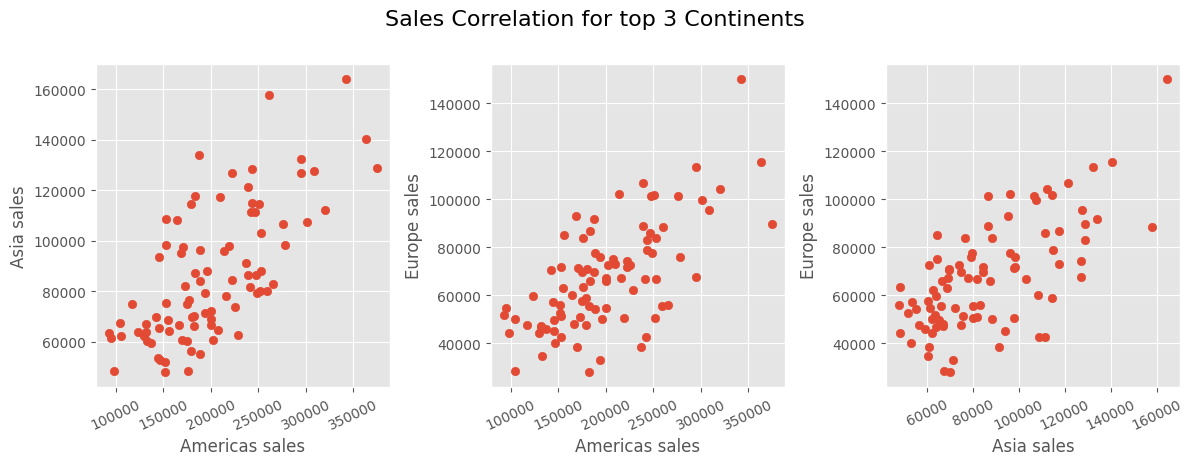

In [ ]:
# Sales correlation for top 3 continents
top_continents = sales_by_continent.iloc[:3, 0]

sales_continents = (
    session_order_df[session_order_df['continent'].isin(top_continents)]
    .pivot_table(values='price',
                 index='date',
                 columns='continent',
                 aggfunc='sum')
    .reset_index()
    )

sales_continent1 = sales_continents.iloc[:88, 1]  # exclude outliers (last 4 days)
sales_continent2 = sales_continents.iloc[:88, 2]
sales_continent3 = sales_continents.iloc[:88, 3]

continent1 = sales_continents.columns[1]
continent2 = sales_continents.columns[2]
continent3 = sales_continents.columns[3]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].scatter(sales_continent1, sales_continent2)
ax[0].set_xlabel(continent1 + ' sales')
ax[0].set_ylabel(continent2 + ' sales')

ax[1].scatter(sales_continent1, sales_continent3)
ax[1].set_xlabel(continent1 + ' sales')
ax[1].set_ylabel(continent3 + ' sales')

ax[2].scatter(sales_continent2, sales_continent3)
ax[2].set_xlabel(continent2 + ' sales')
ax[2].set_ylabel(continent3 + ' sales')

plt.tight_layout()
for axis in ax:
    axis.tick_params(axis='x', rotation=25)

plt.suptitle('Sales Correlation for top 3 Continents', y=1.1)
plt.show()

The graph shows a moderate positive correlation among top 3 continents.

In [ ]:
# Shapiro-Wilk test for sales distribution in top 3 continents
# to choose method for correlation
_, p_value_shapiro_continent1 = shapiro(sales_continent1)
print(f"Shapiro-Wilk p-value for the first continent: {p_value_shapiro_continent1}")

_, p_value_shapiro_continent2 = shapiro(sales_continent2)
print(f"Shapiro-Wilk p-value for the second continent: {p_value_shapiro_continent2}")

_, p_value_shapiro_continent3 = shapiro(sales_continent3)
print(f"Shapiro-Wilk p-value for the third continent: {p_value_shapiro_continent3}")

Shapiro-Wilk p-value for the first continent: 0.042468562628999736
Shapiro-Wilk p-value for the second continent: 0.0003820857396580246
Shapiro-Wilk p-value for the third continent: 0.007309892924070338


The p-value is less than 0.05, therefore the hypothesis that the data is normally distributed is rejected.

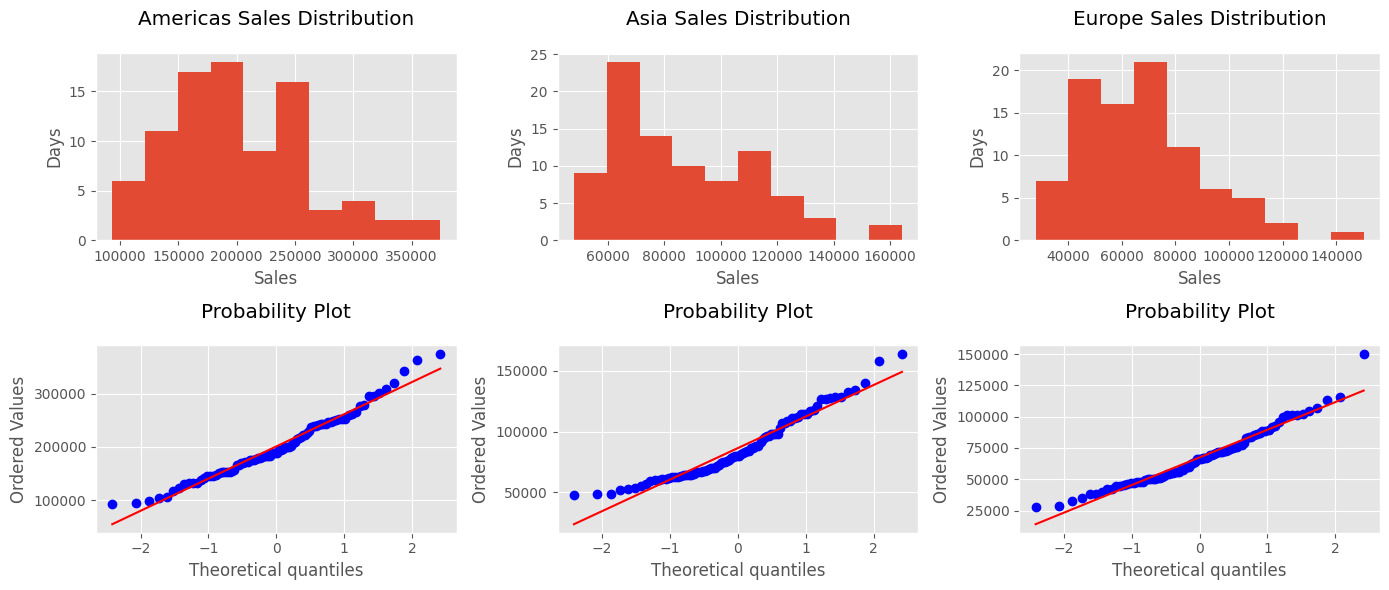

In [ ]:
# Graphical analysis (to double check test results)
fig, ax = plt.subplots(2, 3, figsize=(14, 6))

ax[0, 0].hist(sales_continent1)
ax[0, 0].set_title(f'{continent1} Sales Distribution')
ax[0, 0].set_xlabel('Sales')
ax[0, 0].set_ylabel('Days')

ax[0, 1].hist(sales_continent2)
ax[0, 1].set_title(f'{continent2} Sales Distribution')
ax[0, 1].set_xlabel('Sales')
ax[0, 1].set_ylabel('Days')

ax[0, 2].hist(sales_continent3)
ax[0, 2].set_title(f'{continent3} Sales Distribution')
ax[0, 2].set_xlabel('Sales')
ax[0, 2].set_ylabel('Days')


# The quantile-quantile (q-q plot) plot for determining
# if a dataset follows a normal distribution.
from scipy.stats import probplot

probplot(sales_continent1, dist='norm', plot=ax[1, 0])
probplot(sales_continent2, dist='norm', plot=ax[1, 1])
probplot(sales_continent3, dist='norm', plot=ax[1, 2])

plt.tight_layout()
plt.show()

The graphs showing the distribution of sales for different continents show that the data is not normally distributed. On the q-q plots there are also some deviations from a straight diagonal line, which means that our data is not normally distributed.

In [ ]:
spearman_corr_12 = spearmanr(sales_continent1, sales_continent2)
print(
    f"Spearman Correlation for {continent1} and {continent2}:\n {spearman_corr_12}\n"
)

spearman_corr_13 = spearmanr(sales_continent1, sales_continent3)
print(
    f"Spearman Correlation for {continent1} and {continent3}:\n {spearman_corr_13}\n"
)

spearman_corr_23 = spearmanr(sales_continent2, sales_continent3)
print(
    f"Spearman Correlation for {continent2} and {continent3}:\n {spearman_corr_23}\n"
)

Spearman Correlation for Americas and Asia:
 SignificanceResult(statistic=np.float64(0.6685393258426968), pvalue=np.float64(1.1001059722381636e-12))

Spearman Correlation for Americas and Europe:
 SignificanceResult(statistic=np.float64(0.6258849635447854), pvalue=np.float64(7.009052955139405e-11))

Spearman Correlation for Asia and Europe:
 SignificanceResult(statistic=np.float64(0.6082209150787222), pvalue=np.float64(3.2731384105062476e-10))



Top 3 continents have moderate correlation in sales with Spearman's coefficients 0.67 for Americas and Asia, 0.63 for Americas and Europe, 0.61 for Asia and Europe. P-value < 0.05 indicates that the results sre statistically significant.

## Sales by channel correlation

In [ ]:
sales_channels = (
    pd.pivot_table(session_order_df,
                   values='price',
                   index='date',
                   columns='channel',
                   aggfunc='sum')
    .reset_index()
    )[:88] # excluding outliers

# Checking if data is normally distributed
for col in sales_channels.columns[1:]:
  print(f'Channel: {col}')
  print(shapiro(sales_channels[col]), end='\n\n')

Channel: Direct
ShapiroResult(statistic=np.float64(0.9627333315701925), pvalue=np.float64(0.012486076318203962))

Channel: Organic Search
ShapiroResult(statistic=np.float64(0.9267870193583199), pvalue=np.float64(9.599991143695942e-05))

Channel: Paid Search
ShapiroResult(statistic=np.float64(0.9649007192209844), pvalue=np.float64(0.017435847676207643))

Channel: Social Search
ShapiroResult(statistic=np.float64(0.9766690958935521), pvalue=np.float64(0.1130966509154806))

Channel: Undefined
ShapiroResult(statistic=np.float64(0.9437286946525185), pvalue=np.float64(0.000817556026299742))



The data has a mix of distributions: all the p-values are smaller than 0.05, except for Social Search. Therefore, we reject the null hypothesis that the data is normally distributed for all channels except Social Search.

In [ ]:
# Function for calculating spearman correlation and p-values

def spearman_pvalue(df):
  n = len(df.columns)
  col = df.columns
  corr_matrix = pd.DataFrame(np.zeros((n, n)), columns=col, index=col)
  p_matrix = pd.DataFrame(np.zeros((n, n)), columns=col, index=col)

  for i in range(n):
    for j in range(n):
      corr, p = spearmanr(df[col[i]], df[col[j]])
      corr_matrix.iloc[i, j] = corr
      p_matrix.iloc[i, j] = p

  return corr_matrix, p_matrix

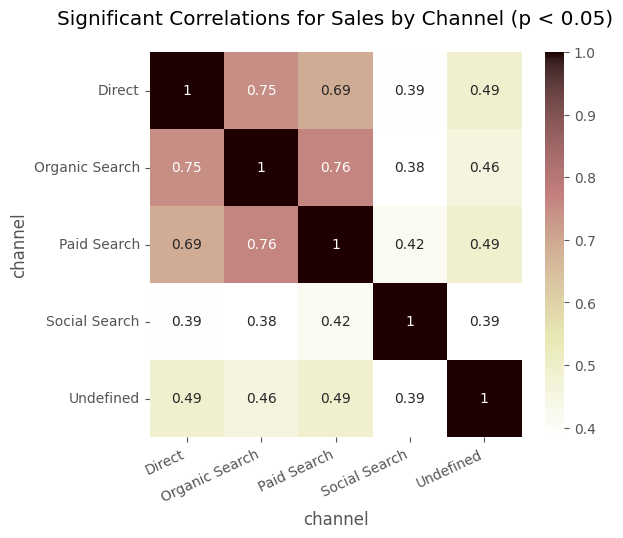

In [ ]:
# A correlation matrix for sales by channels
corr_channels, p_channels = spearman_pvalue(sales_channels.iloc[:, 1:])

mask = p_channels > 0.05  # mask non-significant correlations

plt.figure(figsize=(6, 5))
sns.heatmap(corr_channels, cmap='pink_r', annot=True, mask=mask)
plt.title('Significant Correlations for Sales by Channel (p < 0.05)')
plt.xticks(rotation=25, ha='right')
plt.show()

The results of correlations for sales across different traffic channels are statistically significant. Organic Search, Direct, and Paid Search have strong positive correlation. All the other channels have moderate level of positive correlatin and Social Search correlates the least with the others.

## Sales by category correlation

In [ ]:
top_5_categories = sales_by_category.iloc[:5, 0]

sales_top_categories = (
    session_order_df[session_order_df['product_category']
                     .isin(top_5_categories)]
    .pivot_table(values='price',
                 index='date',
                 columns='product_category',
                 aggfunc='sum')
    .reset_index()) # already 88, because there were no sales (product_category) in the last four days

# Checking if data is normally distributed
for col in sales_top_categories.columns[1:]:
  print(f'Category: {col}')
  print(shapiro(sales_top_categories[col]), end='\n\n')

Category: Beds
ShapiroResult(statistic=np.float64(0.9502172398839275), pvalue=np.float64(0.001990313417105756))

Category: Bookcases & shelving units
ShapiroResult(statistic=np.float64(0.9604356648389608), pvalue=np.float64(0.008807256782666481))

Category: Cabinets & cupboards
ShapiroResult(statistic=np.float64(0.9561694649352347), pvalue=np.float64(0.004672141747344718))

Category: Chairs
ShapiroResult(statistic=np.float64(0.9426548736704264), pvalue=np.float64(0.0007083935880594534))

Category: Sofas & armchairs
ShapiroResult(statistic=np.float64(0.9625642232396963), pvalue=np.float64(0.012167254393811892))



The hypothesis of normality can be rejected for all categories. To calculate correlation, it is better to use Spearman's method.


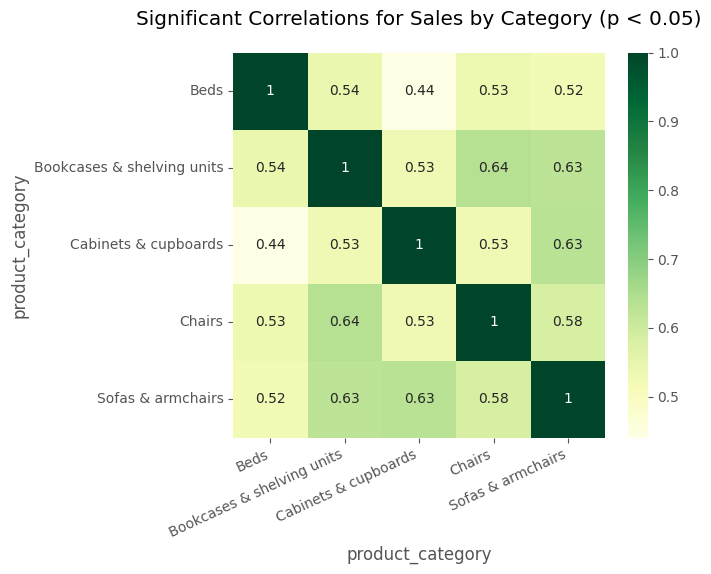

In [ ]:
# A correlation matrix for sales by category
corr_categories, p_categories = spearman_pvalue(sales_top_categories.iloc[:, 1:])

mask = p_categories > 0.05

plt.figure(figsize=(6, 5))
sns.heatmap(corr_categories, cmap='YlGn', annot=True, mask=mask)
plt.title('Significant Correlations for Sales by Category (p < 0.05)')
plt.xticks(rotation=25, ha='right')
plt.show()

There is a moderate positive correlation among all categories.

## Sales by device correlation

In [ ]:
sales_devices = (
    pd.pivot_table(session_order_df,
                   values='price',
                   index='date',
                   columns='device',
                   aggfunc='sum')
    .reset_index())[:88] # excluding outliers

# Checking if data is normally distributed
for col in sales_devices.columns[1:]:
  print(f'Device: {col}')
  print(shapiro(sales_devices[col]), end='\n\n')

Device: desktop
ShapiroResult(statistic=np.float64(0.9639075657546055), pvalue=np.float64(0.014953922836653123))

Device: mobile
ShapiroResult(statistic=np.float64(0.9476004264737546), pvalue=np.float64(0.0013833273219671016))

Device: tablet
ShapiroResult(statistic=np.float64(0.9360479751397734), pvalue=np.float64(0.000300223199948774))



The hypothesis of normality can be rejected for all devices. To calculate correlation, it is better to use Spearman's method.

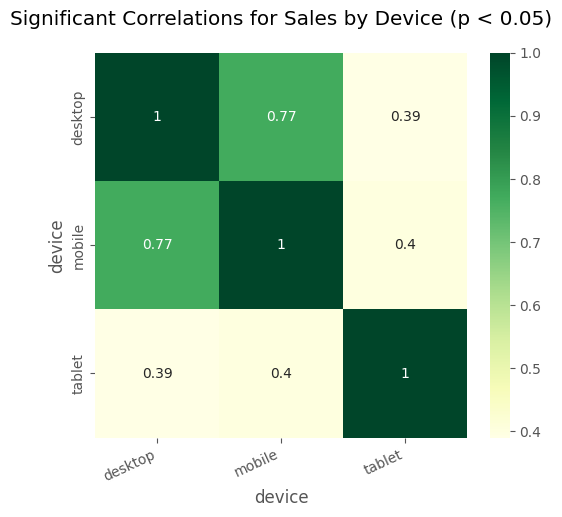

In [ ]:
corr_devices, p_devices = spearman_pvalue(sales_devices.iloc[:, 1:])

mask = p_devices > 0.05

plt.figure(figsize=(6, 5))
sns.heatmap(corr_devices, cmap='YlGn', annot=True, mask=mask)
plt.title('Significant Correlations for Sales by Device (p < 0.05)')
plt.xticks(rotation=25, ha='right')
plt.show()

Mobile and desktop devices have strong positive correlation. Tablet has moderate positive correlation with desktop and mobile devices.

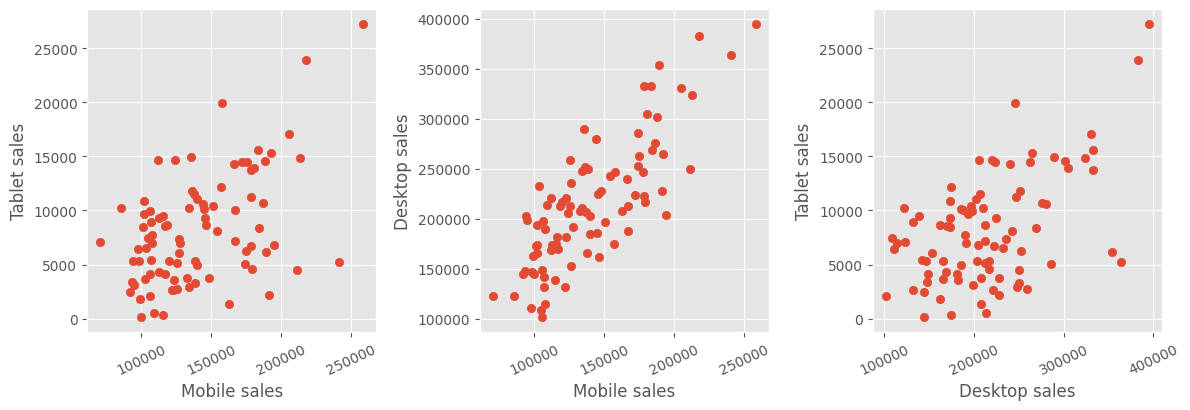

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].scatter(sales_devices['mobile'], sales_devices['tablet'])
ax[0].set_xlabel('Mobile sales')
ax[0].set_ylabel('Tablet sales')

ax[1].scatter(sales_devices['mobile'], sales_devices['desktop'])
ax[1].set_xlabel('Mobile sales')
ax[1].set_ylabel('Desktop sales')

ax[2].scatter(sales_devices['desktop'], sales_devices['tablet'])
ax[2].set_xlabel('Desktop sales')
ax[2].set_ylabel('Tablet sales')

plt.tight_layout()
for axis in ax:
    axis.tick_params(axis='x', rotation=25)

plt.show()

Visual representation of strong (for desktop and mobile devices) and moderate (for tablet and mobile or tablet and desktop devices) correlation.

# Statistical analysis of differences between groups

## Sales for registered and not registered users

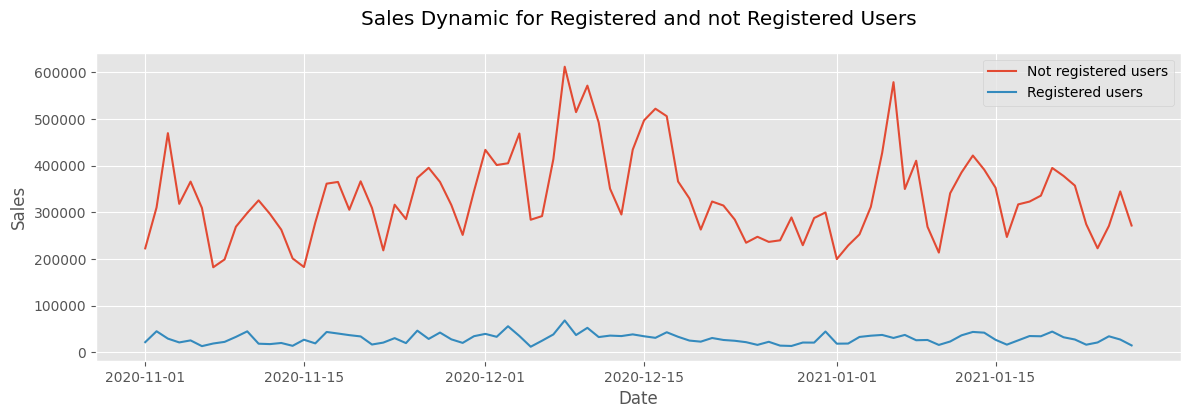

In [ ]:
# Sales for registered and not registered users dynamic
sales_registered = (
    session_order_df[session_order_df['account_id'].notnull()]
    .groupby('date')['price']
    .agg(sales=('sum'))
    .reset_index()
    )

sales_not_registered = (
    session_order_df[session_order_df['account_id'].isnull()]
    .groupby('date')['price']
    .agg(sales=('sum'))
    .reset_index()
    )[:88]

plt.plot('date', 'sales', data=sales_not_registered)
plt.plot('date', 'sales', data=sales_registered)
plt.legend(['Not registered users', 'Registered users'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Dynamic for Registered and not Registered Users')
plt.show()

In [ ]:
orders_registered = (session_order_df[session_order_df['account_id'].notnull()
 & session_order_df['product_name'].notnull()].shape[0])
print(f'Number of orders from registered users: {orders_registered}')

orders_not_registered = (session_order_df[session_order_df['account_id'].isnull()
 & session_order_df['product_name'].notnull()].shape[0])
print(f'Number of orders from not registered users: {orders_not_registered}')

Number of orders from registered users: 2781
Number of orders from not registered users: 30757


In [ ]:
# Shapiro-Wilk test
_, p_value_shapiro_sales_r = shapiro(sales_registered['sales'])
_, p_value_shapiro_sales_not_r = shapiro(sales_not_registered['sales'])

# Test results
print(f"Shapiro-Wilk for sales from registered users data p-value: {p_value_shapiro_sales_r}")
print(f"Shapiro-Wilk for sales from not registered users data p-value: {p_value_shapiro_sales_not_r}")

Shapiro-Wilk for sales from registered users data p-value: 0.007295139880540744
Shapiro-Wilk for sales from not registered users data p-value: 0.0026183359245325936


The Shapiro-Wilk method is used because it is better suited for small sample sizes. The p-value is less than 0.05, therefore the hypothesis that the data is normally distributed is rejected. Therefore the Mann-Whitney test is better for sample comparison.

In [ ]:
from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U test
u_stat, p_value = (mannwhitneyu(sales_registered['sales'],
                               sales_not_registered['sales']))

print(f"U-statistic: {u_stat}, p-value: {p_value}")

U-statistic: 0.0, p-value: 2.2159276950123465e-30


The p-value is 2.2159276950123465e-30, which is less than 0.05, meaning that there is a statistically significant difference in sales between registered and unregistered users. Unregistered users buy significantly more, as can be seen from the plot.

## Number of sessions for different channels

In [ ]:
session_cnt_channels = (
    pd.pivot_table(session_order_df,
                   values='ga_session_id',
                   index='date',
                   columns='channel',
                   aggfunc='count')
    )[:88]

# Checking if data is normally distributed
for col in session_cnt_channels.columns:
  print(f'Channel: {col}')
  print(shapiro(session_cnt_channels[col]), end='\n\n')

Channel: Direct
ShapiroResult(statistic=np.float64(0.9711719324100192), pvalue=np.float64(0.04684284582084014))

Channel: Organic Search
ShapiroResult(statistic=np.float64(0.9667395490509751), pvalue=np.float64(0.02322342693371155))

Channel: Paid Search
ShapiroResult(statistic=np.float64(0.9645586254902366), pvalue=np.float64(0.016535898889849687))

Channel: Social Search
ShapiroResult(statistic=np.float64(0.9794998062530369), pvalue=np.float64(0.17740370840264302))

Channel: Undefined
ShapiroResult(statistic=np.float64(0.9726004579189096), pvalue=np.float64(0.058871751035083054))



The data has a mix of distributions: all the p-values are smaller than 0.05, except for Social Search and Undefined. Therefore, we reject the null hypothesis that the data is normally distributed for all channels except Social Search and Undefined.

In [ ]:
from scipy.stats import kruskal

_, p_value = kruskal(session_cnt_channels['Direct'],
                     session_cnt_channels['Organic Search'],
                     session_cnt_channels['Paid Search'],
                     session_cnt_channels['Social Search'],
                     session_cnt_channels['Undefined'])

print(f"P-value for Kruskal-Wallis test: {p_value}")

print("Mean value for Direct channel:", session_cnt_channels['Direct'].mean())
print("Mean value for Organic Search:", session_cnt_channels['Organic Search'].mean())
print("Mean value for Paid Search:", session_cnt_channels['Paid Search'].mean())
print("Mean value for Social Search:", session_cnt_channels['Social Search'].mean())
print("Mean value for Undefined:", session_cnt_channels['Undefined'].mean())

P-value for Kruskal-Wallis test: 5.186401227135924e-75
Mean value for Direct channel: 888.3863636363636
Mean value for Organic Search: 1360.0795454545455
Mean value for Paid Search: 1031.0227272727273
Mean value for Social Search: 304.72727272727275
Mean value for Undefined: 234.82954545454547


We rejected the null hypothesis that the data is normally distributed for all channels except Social Search and Undefined. Thats why we apply the Kruskal-Wallis test for number of sessions comparison.

There is a statistically significant difference in number of sessions across the channels, because the p-value is much smaller than 0.05.

## The share of sessions with organic traffic in Europe and America

In [ ]:
# Creating pivot table with data to analyze
session_cnt_channel_continent = (
    pd.pivot_table(session_order_df,
                   values='ga_session_id',
                   index='channel',
                   columns='continent',
                   aggfunc='count')
    )

print(session_cnt_channel_continent)

continent       (not set)  Africa  Americas   Asia  Europe  Oceania
channel                                                            
Direct                192     839     44982  19392   15163      814
Organic Search        302    1243     68671  29717   23195     1297
Paid Search           189    1018     52188  22335   17561     1050
Social Search          67     284     15372   6625    5249      317
Undefined              45     236     11966   5044    3967      225


In [ ]:
import statsmodels.api as sm

sessions_europe = session_cnt_channel_continent['Europe'].sum()
sessions_americas = session_cnt_channel_continent['Americas'].sum()
organic_s_europe = session_cnt_channel_continent.loc['Organic Search', 'Europe']
organic_s_americas = session_cnt_channel_continent.loc['Organic Search', 'Americas']
not_organic_s_europe = sessions_europe - organic_s_europe
not_organic_s_americas = sessions_americas - organic_s_americas

z_stat, p_value = sm.stats.proportions_ztest([organic_s_europe, organic_s_americas],
 [sessions_europe, sessions_americas])

print(f'Z-statistic: {z_stat}')
print(f'P-value: {p_value}')

Z-statistic: 0.28951412926103953
P-value: 0.7721879690501752


There is no statistically significant difference between the share of organic sessions in total sessions for Americas and Europe.

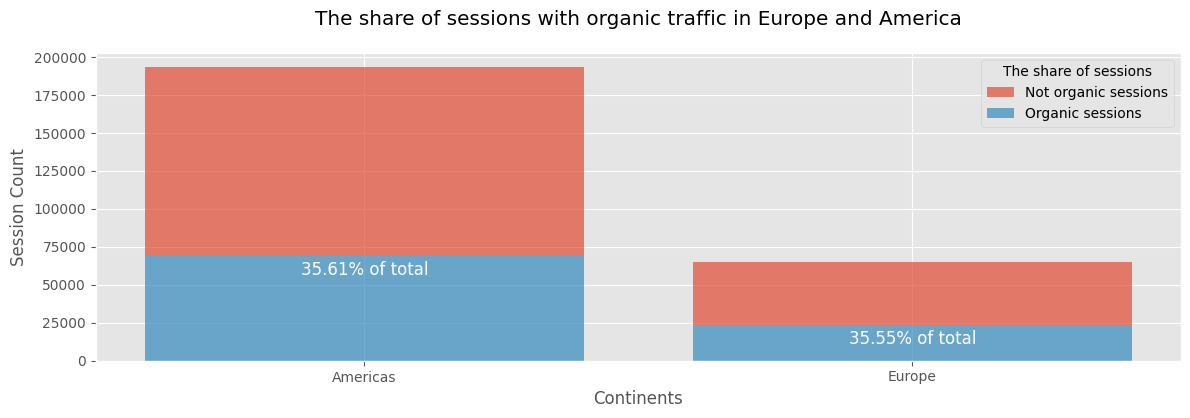

In [ ]:
# Data to show
x = ['Americas', 'Europe']
not_org_s = [not_organic_s_americas, not_organic_s_europe]
org_s = [organic_s_americas, organic_s_europe]

# Plot bars in stack manner
plt.bar(x, not_org_s, bottom=org_s, alpha=0.7)
bars = plt.bar(x, org_s, alpha=0.7)

# Creating labels
labels = [round(organic_s_europe / sessions_europe * 100, 2),
          round(organic_s_americas / sessions_americas * 100, 2)]

for bar, label in zip(bars, labels):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() - 15000,
        f'{label}% of total',
        ha="center",
        va="bottom",
        color='white',
        fontsize=12
    )

plt.legend(['Not organic sessions', 'Organic sessions'], title='The share of sessions')
plt.title('The share of sessions with organic traffic in Europe and America')
plt.xlabel('Continents')
plt.ylabel('Session Count')
plt.show()

The proportion of organic sessions is almost the same for both continents.

# Tableau dashboards


[Dashboards](https://public.tableau.com/app/profile/kateryna.fen/viz/FurnitureStoreAnalysis_17574438535780/Overview#2)